In [24]:
import sys
# Please modify the path below to the directory where MyLibrary is located in your PC.
sys.path.append( r'C:\Users\Jess\Dropbox\UTokyo\Research\Cellulose\code\AFM analysis\MyImageProcessingLibrary-Ito_develop\MyImageProcessingLibrary-Ito_develop')

import pprint
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np
from MyLibrary import imptools
from MyLibrary.BG_Calibrator import BG_Calibrator
from MyLibrary.ProcessedImageClass import ProcessedImage
from MyLibrary.KinkDetecter import KinkDetecter
from MyLibrary.Segmentater import Segmentater
from MyLibrary.Skeletonizer import Skeletonizer

In [25]:
# Load the text data of the AFM image
path_to_data = Path('../example/example_data/example_data.txt') # Modify the path to the data file.
AFM_data = np.loadtxt(path_to_data, skiprows=1) # Modify the skiprows argument according to the format of your data.
image_size = int(np.sqrt(len(AFM_data)))  # The number of pixels per side of the AFM image.
height_data = AFM_data.reshape((image_size, image_size)) # Make sure that the data is in the form of 2D ndarray.

In [26]:
# Define the objects for each processing step.
bg_calibrator = BG_Calibrator()
segmentater = Segmentater()
skeltonizer = Skeletonizer()
# デフォルトでは成す角が150以下の箇所をキンクとして検出する。
kinkdetector = KinkDetecter(threshold_angle_from_decomposed_indices=160 * np.pi / 180)

# Process the image.
image = ProcessedImage(original_AFM=height_data, name='example_data')
bg_calibrator(image)
segmentater(image)
skeltonizer(image)
kinkdetector(image)

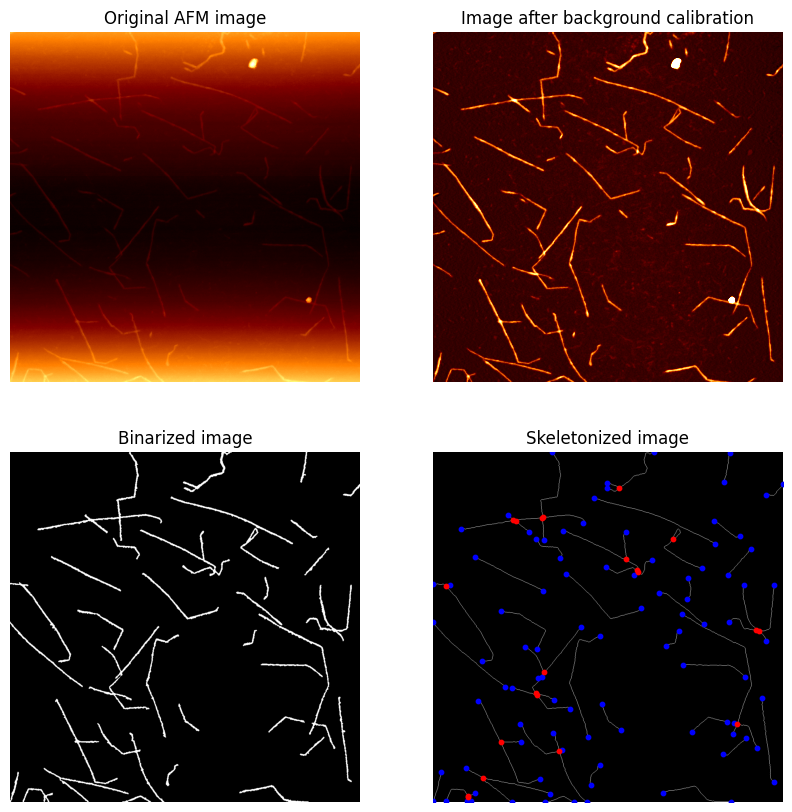

In [27]:
# Display the processed images.
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for a in ax.ravel():
    a.axis('off')
ax[0][0].imshow(image.original_image, cmap='afmhot')
ax[0][0].set_title('Original AFM image')
ax[0][1].imshow(image.calibrated_image, cmap='afmhot', vmin=-0.5, vmax=4.5)
ax[0][1].set_title('Image after background calibration')
ax[1][0].imshow(image.binarized_image, cmap='gray')
ax[1][0].set_title('Binarized image')
ax[1][1].imshow(image.skeleton_image, cmap='gray')
ax[1][1].set_title('Skeletonized image')

# End points and branch points coordinates can be referred by the following attributes of a ProcessedImage instance.
end_points_y, end_points_x = np.where(image.ep)
branch_points_y, branch_points_x = np.where(image.bp)
ax[1][1].scatter(end_points_x, end_points_y, c='blue', s=10)
ax[1][1].scatter(branch_points_x, branch_points_y, c='red', s=10)

plt.show()

In [28]:
# Please check the attributes of the ProcessedImage instance.
# Some feature of the ProcessedImage instances are subject to change in the future.
# If you have any questions, please contact Tomoki Ito.
pprint.pprint(dir(image))

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_calc_endpoint_indices',
 '_calc_kink_and_decomposed_point_indices',
 '_generate_fiber_instances',
 '_get_kink_angles_in_fiber',
 'all_kink_angles',
 'all_kink_coordinates',
 'binarized_image',
 'bp',
 'calibrated_image',
 'data',
 'decomposed_point_coordinates',
 'ep',
 'fibers_in_image',
 'get_height_distribution',
 'label_image',
 'nLabels',
 'name',
 'original_image',
 'size_per_pixel',
 'skeleton_image',
 'specific_height_fibers']


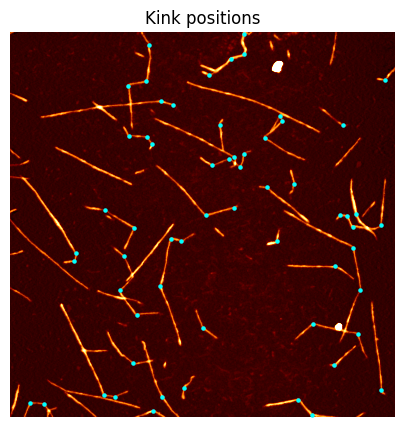

In [29]:
all_kink_coor_x, all_kink_coor_y = image.all_kink_coordinates
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.axis('off')
ax.imshow(image.calibrated_image, cmap='afmhot', vmin=-0.5, vmax=4.5)
ax.scatter(all_kink_coor_x, all_kink_coor_y, c='cyan', s=5)
ax.set_title('Kink positions')
plt.show()

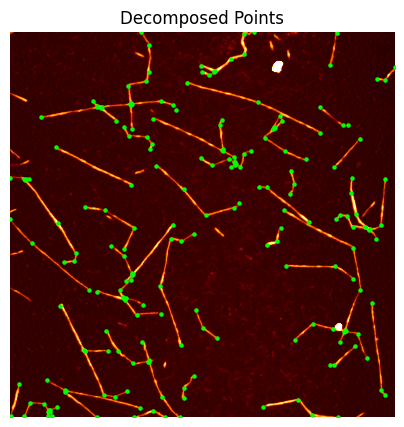

In [30]:
# Display the decomposed_points used for detection as kink candidates.
# The Douglas-Peucker algorithm is used to detect decomposed points.　
decomposed_coor_x, decomposed_coor_y = image.decomposed_point_coordinates
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.axis('off')
ax.imshow(image.calibrated_image, cmap='afmhot', vmin=-0.5, vmax=4.5)
# 現状では、decomposed_pointsはfiberの端点を含んでいる。使用者は必要に応じて無視してくれ。
ax.scatter(decomposed_coor_x, decomposed_coor_y, c='lime', s=5)
ax.set_title('Decomposed Points')
plt.show()

## AFM像中の全てのセグメントを抽出する。

In [31]:
fibers = image.fibers_in_image()
print(type(fibers))
print(type(fibers[0]))
print(len(fibers))

<class 'list'>
<class 'FiberClass.Fiber'>
71


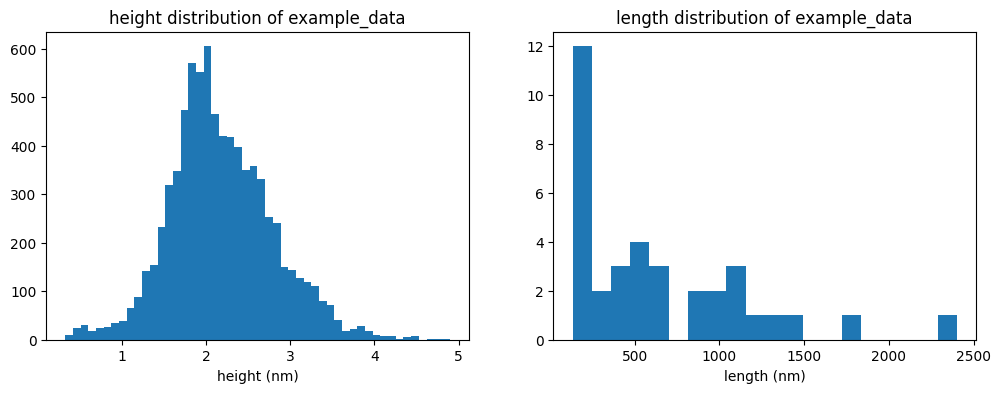

In [32]:
# Some examples to show the results are as follows.


# The height and length distribution
height = image.calibrated_image[np.where(image.skeleton_image)]
length = list()
for i in range(1, image.nLabels):
    y, x, h, w, area = image.data[i]
    l = imptools.get_length(image.skeleton_image[x: x + w, y: y + h])
    length.append(l)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes.ravel()
ax[0].hist(height, bins=50)
ax[0].set_xlabel('height (nm)')
ax[0].set_title('height distribution of ' + image.name)
ax[1].hist(length, bins=20)
ax[1].set_xlabel('length (nm)')
ax[1].set_title('length distribution of ' + image.name)
plt.show()

## 特定のセグメントを抽出する

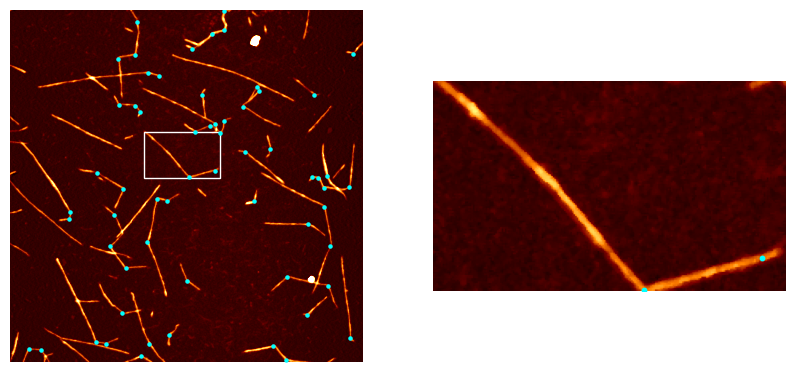

In [ ]:
target_fiber = fibers[25] # Choose a fiber to analyze.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].axis('off')
ax[1].axis('off')

ax[0].imshow(image.calibrated_image, cmap='afmhot', vmin=-0.5, vmax=4.5)
x, y, h, w, area = target_fiber.data # The position of the fiber is described by the coordinates of the upper-left corner and the width and height of the rectangle.
ax[0].add_patch(plt.Rectangle((x, y), h, w, linewidth=1, edgecolor='white', facecolor='none'))
all_kink_coor_x, all_kink_coor_y = image.all_kink_coordinates
ax[0].scatter(all_kink_coor_x, all_kink_coor_y, c='cyan', s=5)

ax[1].imshow(target_fiber.fiber_image, cmap='afmhot', vmin=-0.5, vmax=4.5)
kink_indices = target_fiber.kink_indices
if len(kink_indices) >0:
    ax[1].scatter(target_fiber.xtrack[kink_indices], target_fiber.ytrack[kink_indices], c='cyan', s=10)
# ax[1].scatter(target_fiber.xtrack, target_fiber.ytrack, c='cyan', s=10)
plt.show()



## セグメントの高さプロファイル、およびキンク、端点の位置を表示する。

/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_12085/3133720539.py:51: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


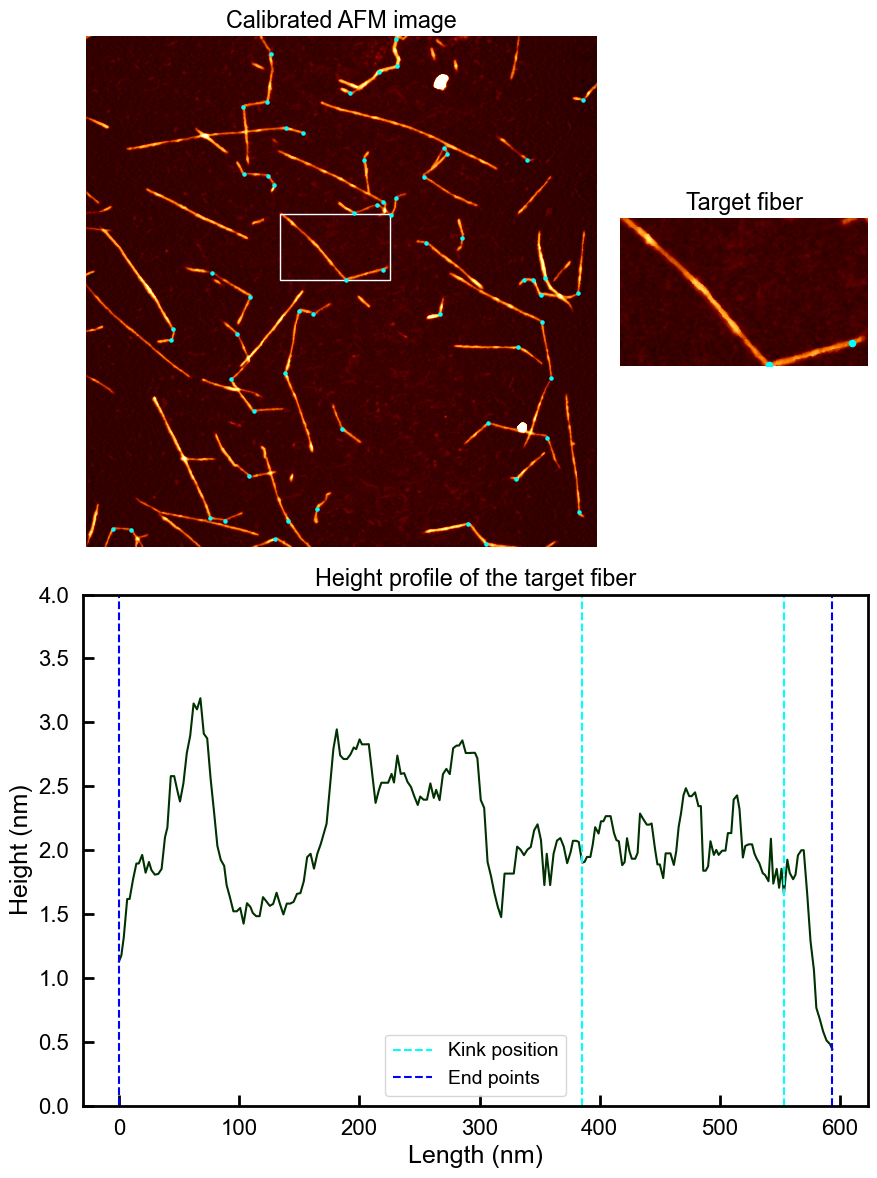

kink_angles: [2.01426413 2.69693011] radian


In [ ]:
# Fiber instances are saved in image.fibers_in_image.
target_fiber = fibers[25] # Choose a fiber to analyze.

# Display the fiber.
fig = plt.figure(layout='constrained', figsize=(9, 12))

gs = GridSpec(4 , 3, figure=fig)
ax0 = fig.add_subplot(gs[0:2, 0:2])
ax0.axis('off')
ax1 = fig.add_subplot(gs[0:2, 2:3])
ax1.axis('off')
ax2 = fig.add_subplot(gs[2:, :])

ax0.imshow(image.calibrated_image, cmap='afmhot', vmin=-0.5, vmax=4.5) # Display the processed AFM image.
ax0.set_title('Calibrated AFM image')
ax1.imshow(target_fiber.fiber_image, cmap='afmhot', vmin=-0.5, vmax=4.5) # Display the target fiber.
ax1.set_title('Target fiber')

#Draw a rectangle at the position of the displayed fiber.
x, y, h, w, area = target_fiber.data # The position of the fiber is described by the coordinates of the upper-left corner and the width and height of the rectangle.
ax0.add_patch(plt.Rectangle((x, y), h, w, linewidth=1, edgecolor='white', facecolor='none'))

# Display the kink positions in the processed AFM image.
kink_xcoors, kink_ycoors = image.all_kink_coordinates
if len(kink_xcoors) > 0: # If there are no kinks in the image, the following line will cause an error.
    ax0.scatter(kink_xcoors, kink_ycoors, c='cyan', s=5)

# Display the kink positions in the target fiber image.
kink_indices = target_fiber.kink_indices # the positions of the kinks in the fiber is described by the indices of the skeletonized pixel in the fiber.
if len(kink_indices) > 0: # If there are no kinks in the fiber, the following line will cause an error.
    ax1.scatter(target_fiber.xtrack[kink_indices], target_fiber.ytrack[kink_indices], c='cyan', s=20)

# Display the horizontal and vertical profiles of the target fiber.
ax2.plot(target_fiber.horizon, target_fiber.height)
# display kink position in height profile
for k in kink_indices:
    line = ax2.axvline(x=target_fiber.horizon[k], color='cyan', linestyle='--')
line.set_label('Kink position')

# Display the endpoint position in height profile
for e in target_fiber.ep_indices:
    line = ax2.axvline(x=target_fiber.horizon[e], color='blue', linestyle='--')
line.set_label('End points')

ax2.set_xlabel('Length (nm)')
ax2.set_ylabel('Height (nm)')
ax2.set_title('Height profile of the target fiber')
ax2.set_ylim(0, 4)
ax2.legend()

plt.tight_layout()
plt.show()

print(f'kink_angles: {target_fiber.kink_angles} radian')

## キンクの検出に使用した、CNFを折れ線近似する際の分割点も表示可能。

/var/folders/2r/qm7h3hs16fz262zr85x3_ps40000gp/T/ipykernel_12085/852815461.py:45: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


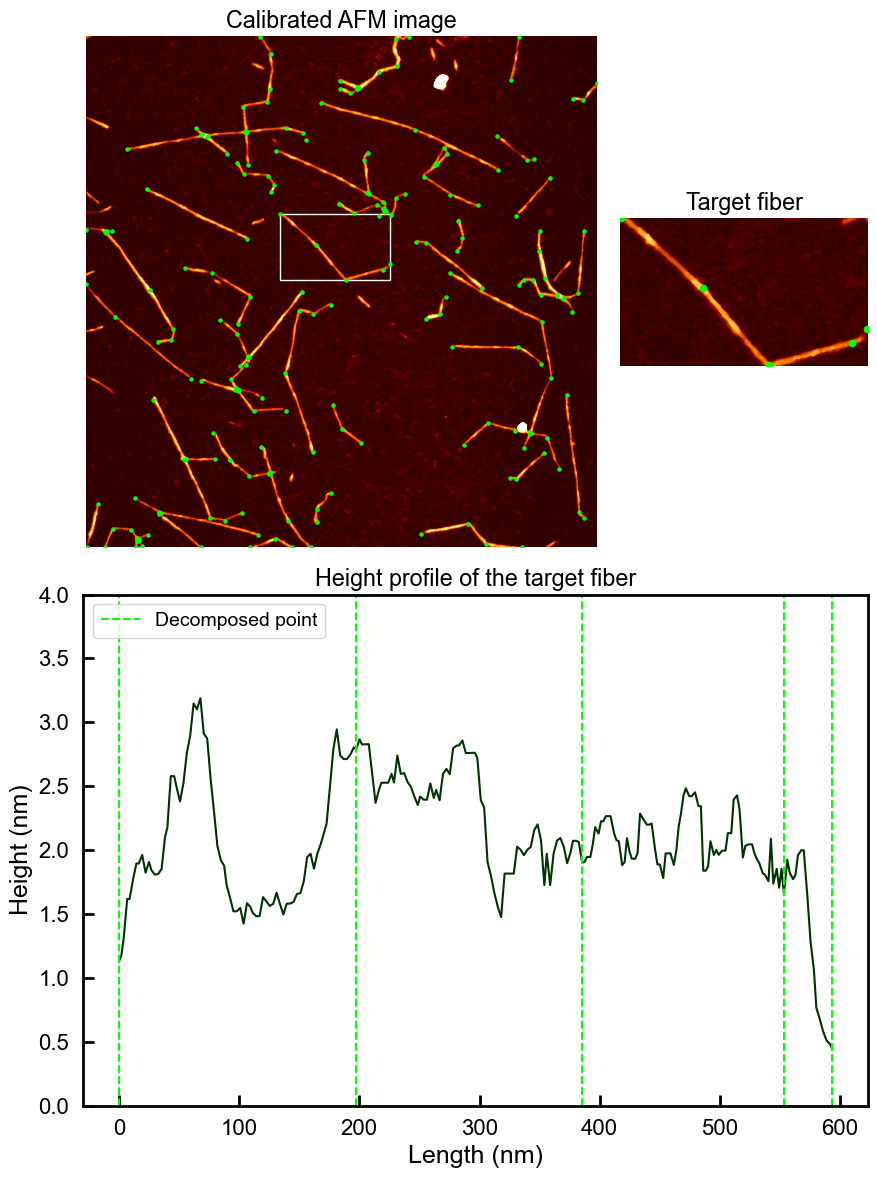

In [ ]:
# Fiber instances are saved in image.fibers_in_image.
target_fiber = fibers[25] # Choose a fiber to analyze.

# Display the fiber.
fig = plt.figure(layout='constrained', figsize=(9, 12))

gs = GridSpec(4 , 3, figure=fig)
ax0 = fig.add_subplot(gs[0:2, 0:2])
ax0.axis('off')
ax1 = fig.add_subplot(gs[0:2, 2:3])
ax1.axis('off')
ax2 = fig.add_subplot(gs[2:, :])

ax0.imshow(image.calibrated_image, cmap='afmhot', vmin=-0.5, vmax=4.5) # Display the processed AFM image.
ax0.set_title('Calibrated AFM image')
ax1.imshow(target_fiber.fiber_image, cmap='afmhot', vmin=-0.5, vmax=4.5) # Display the target fiber.
ax1.set_title('Target fiber')

#Draw a rectangle at the position of the displayed fiber.
x, y, h, w, area = target_fiber.data # The position of the fiber is described by the coordinates of the upper-left corner and the width and height of the rectangle.
ax0.add_patch(plt.Rectangle((x, y), h, w, linewidth=1, edgecolor='white', facecolor='none'))

# Display the decomposed points in the processed AFM image.
decomposed_x, decomposed_y = image.decomposed_point_coordinates
if len(decomposed_x) > 0: # If there are no kinks in the image, the following line will cause an error.
    ax0.scatter(decomposed_x, decomposed_y, c='lime', s=5)

# Display the kink positions in the target fiber image.
decomposed_indices = target_fiber.decomposed_point_indices # the positions of the kinks in the fiber is described by the indices of the skeletonized pixel in the fiber.
if len(decomposed_indices) > 0: # If there are no kinks in the fiber, the following line will cause an error.
    ax1.scatter(target_fiber.xtrack[decomposed_indices], target_fiber.ytrack[decomposed_indices], c='lime', s=20)

# Display the horizontal and vertical profiles of the target fiber.
ax2.plot(target_fiber.horizon, target_fiber.height)
for i, d in enumerate(decomposed_indices):
    line = ax2.axvline(x=target_fiber.horizon[d], color='lime', linestyle='--')
line.set_label('Decomposed point')

ax2.set_xlabel('Length (nm)')
ax2.set_ylabel('Height (nm)')
ax2.set_title('Height profile of the target fiber')
ax2.set_ylim(0, 4)
ax2.legend()

plt.tight_layout()
plt.show()

## 特定の高さを持つ箇所をFiberインスタンス抽出する。
使用方法は、先ほどのセグメントと全く同じ。呼び出すメソッドが違うのみ。

In [ ]:
# return the list of fiber instances whose height is within the specified range.
specified_fibers = image.specific_height_fibers(1.6, 2.02, include_upper_limit=False)

In [ ]:
print(type(specified_fibers[0]))

<class 'FiberClass.Fiber'>


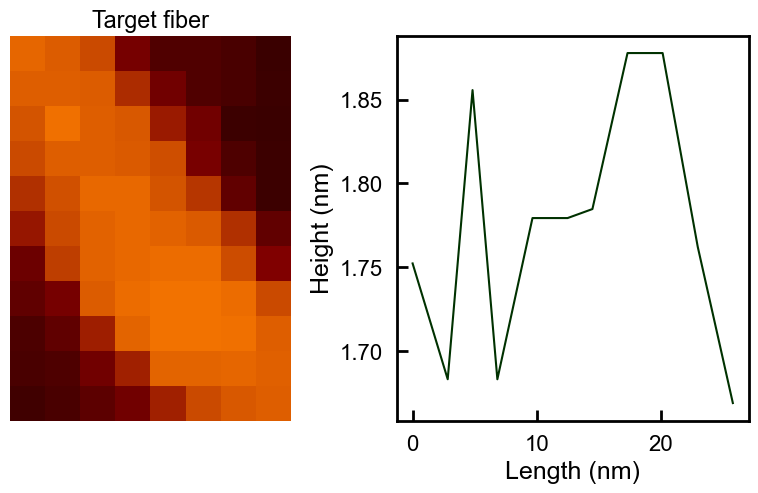

In [ ]:
target = specified_fibers[0]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].axis('off')

ax[0].imshow(target.fiber_image, cmap='afmhot', vmin=-0.5, vmax=4.5)
ax[0].set_title('Target fiber')

ax[1].plot(target.horizon, target.height)
ax[1].set_xlabel('Length (nm)')
ax[1].set_ylabel('Height (nm)')
plt.show()

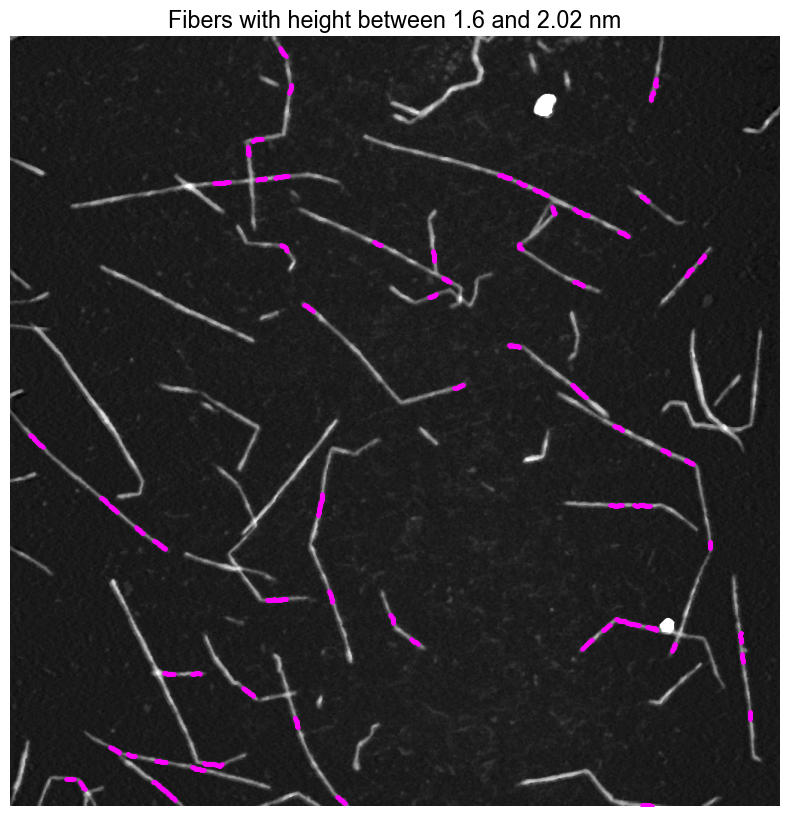

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.axis('off')

ax.imshow(image.calibrated_image, cmap='gray', vmin=-0.5, vmax=4.5)
for fiber in specified_fibers:
    x, y, h, w, area = fiber.data
    ax.scatter(fiber.xtrack + x, fiber.ytrack + y, c='magenta', s=5)

ax.set_title('Fibers with height between 1.6 and 2.02 nm')

plt.show()

In [ ]:
# Please check the attributes of the Fiber instance.
# Some feature of the Fiber instances are subject to change in the future.
# If you have any questions, please contact Tomoki Ito.
pprint.pprint(dir(target_fiber))

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'data',
 'decomposed_point_indices',
 'ep_indices',
 'fiber_image',
 'height',
 'horizon',
 'kink_angles',
 'kink_indices',
 'length',
 'xtrack',
 'ytrack']


## キンクの箇所の高さを抽出する

61


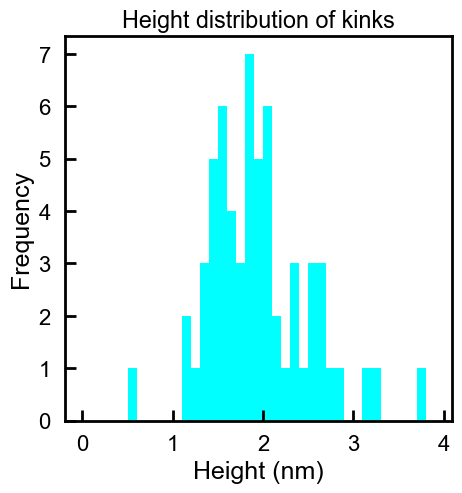

In [ ]:
kink_x, kink_y = image.all_kink_coordinates
kink_height = image.calibrated_image[kink_y, kink_x]
print(len(kink_height))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(kink_height,bins=np.arange(0, 4, 0.1), range=(0, 4), color='cyan')
ax.set_xlabel('Height (nm)')
ax.set_ylabel('Frequency')
ax.set_title('Height distribution of kinks')
plt.show()